In [3]:
import pandas as pd
message = pd.read_csv('dataset//spam.csv', encoding='latin-1')
df = message[['v1', 'v2']]
df.columns = ['label', 'text']

In [4]:
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
df.shape

(5572, 2)

In [6]:
df['text'].loc[100] # 100th text in the dataset

'Okay name ur price as long as its legal! Wen can I pick them up? Y u ave x ams xx'

In [7]:
x = list(df['text'])
y = list(df['label'])
y = list(pd.get_dummies(y, drop_first=True)['spam'])

In [8]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [9]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

train_encoding = tokenizer(x_train, truncation=True, padding= True)
test_encoding = tokenizer(x_test, truncation=True, padding= True)

c:\Users\Amreet\Desktop\Transformers\transformer\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
# Converting these encodings into Database objects
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encoding),y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encoding),y_test))

In [11]:
from transformers import TFDistilBertForSequenceClassification, TFTrainingArguments

In [12]:
training_args = TFTrainingArguments(
    output_dir = './results',
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

In [13]:
from transformers import DistilBertConfig, TFDistilBertForSequenceClassification

config = DistilBertConfig.from_pretrained("distilbert-base-uncased", num_labels=2)
model = TFDistilBertForSequenceClassification(config)

with training_args.strategy.scope():
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])


TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.


In [14]:
train_dataset = train_dataset.batch(16)
test_dataset = test_dataset.batch(16)

In [15]:
# Train the model (equivalent of trainer.train())
model.fit(train_dataset, validation_data=test_dataset, epochs=2)

Epoch 1/2


279/279 [==============================] - 1564s 6s/step - loss: 0.1155 - accuracy: 0.9641 - val_loss: 0.0550 - val_accuracy: 0.9812
Epoch 2/2
279/279 [==============================] - 1545s 6s/step - loss: 0.0264 - accuracy: 0.9924 - val_loss: 0.0427 - val_accuracy: 0.9892


In [16]:
# Evaluate the model (equivalent of trainer.evaluate())
eval_results = model.evaluate(test_dataset)
print("Evaluation results:", eval_results)

70/70 [==============================] - 102s 1s/step - loss: 0.0427 - accuracy: 0.9892
Evaluation results: [0.042748577892780304, 0.9892376661300659]


In [17]:
# Predict (equivalent of trainer.predict())
predictions = model.predict(test_dataset)
logits = predictions.logits if hasattr(predictions, 'logits') else predictions
pred_labels = tf.argmax(logits, axis=1)
print("Predicted labels:", pred_labels.numpy())

70/70 [==============================] - 103s 1s/step
Predicted labels: [1 0 1 ... 0 0 1]


In [20]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Get predictions
predictions = model.predict(test_dataset)
logits = predictions.logits if hasattr(predictions, 'logits') else predictions

# Convert logits to predicted class labels
pred_labels = np.argmax(logits, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test, pred_labels)
print(cm)


70/70 [==============================] - 102s 1s/step
[[963   2]
 [ 10 140]]


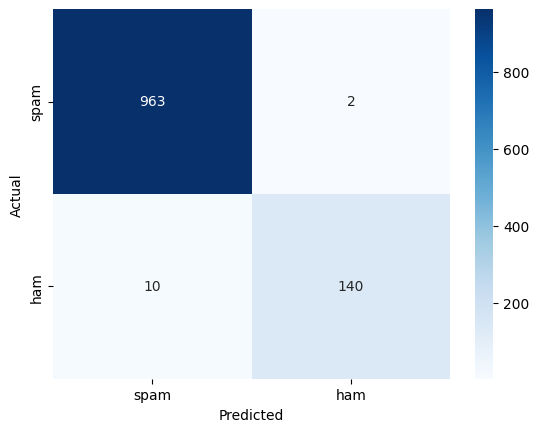

In [21]:
import seaborn as sns
from matplotlib import pyplot as plt
class_names = ['spam','ham']
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()